Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def wrangle(data):
    df = pd.read_csv(data,index_col='Date')
    df.index= pd.to_datetime(df.index)
    df['day_before'] = df['Births'].shift(1)
    df.dropna(inplace=True)

    return df

In [3]:
df = wrangle('data/raw.githubusercontent.com_jbrownlee_Datasets_master_daily-total-female-births.csv')

In [4]:
df

,Births,day_before
Date,,
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
1959-01-06,29,44.0
...,...,...
1959-12-27,37,34.0
1959-12-28,52,37.0
1959-12-29,48,52.0


In [5]:
cutoff = int(len(df)*.75)
X_train = df[['day_before']].loc[:'1959-10-01']
y_train =  df['Births'].loc[:'1959-10-01']
X_test = df[['day_before']].loc['1959-10-02':]
y_test = df['Births'].loc['1959-10-02':]

In [6]:
# Baseline birth number
y_mean =y_train.mean()

In [7]:
y_pred_baseline = [y_mean] * len(X_train)
print(f'The mean absolute error for the baseline is :{round(mean_absolute_error(y_train,y_pred_baseline),2)}')

The mean absolute error for the baseline is :5.88


In [8]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [9]:
# Mean absolute error for training data 
y_pred = model.predict(X_train)
print(f'The mean absolute error for the training data: {round(mean_absolute_error(y_train,y_pred),2)}')

The mean absolute error for the training data: 5.8


In [10]:
# Prediction for the test data
y_pred_test = np.round(model.predict(X_test),2)
print(f'The mean absolute error for the test data: {round(mean_absolute_error(y_test,y_pred_test),2)}')

The mean absolute error for the test data: 4.99


In [11]:
df_test = pd.DataFrame(
    {
        'test':y_test,
        'y_pred':y_pred_test  }
)

<AxesSubplot:xlabel='Date'>

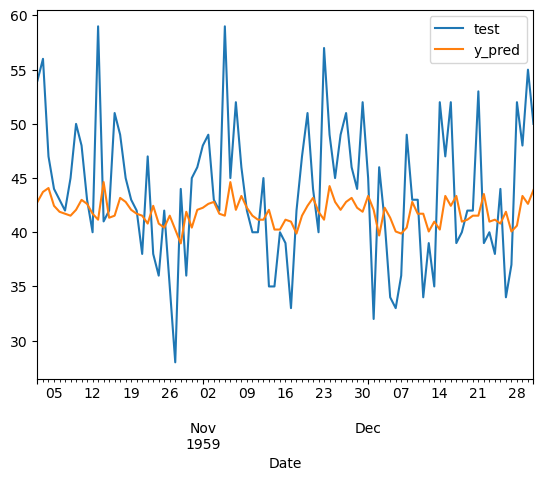

In [12]:
df_test.plot()

In [13]:
df.describe()

,Births,day_before
count,364.000000,364.000000
mean,42.000000,41.958791
std,7.349219,7.346291
min,23.000000,23.000000
25%,37.000000,37.000000
50%,42.000000,42.000000
75%,46.000000,46.000000
max,73.000000,73.000000


## AutoReg Model

In [62]:
def wrangle(data):
    df = pd.read_csv(data,index_col='Date')
    df.index= pd.to_datetime(df.index)
    df = df['Births']
    
    return df

In [63]:
df_b = wrangle('data/raw.githubusercontent.com_jbrownlee_Datasets_master_daily-total-female-births.csv')

In [64]:
df_b

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: Births, Length: 365, dtype: int64

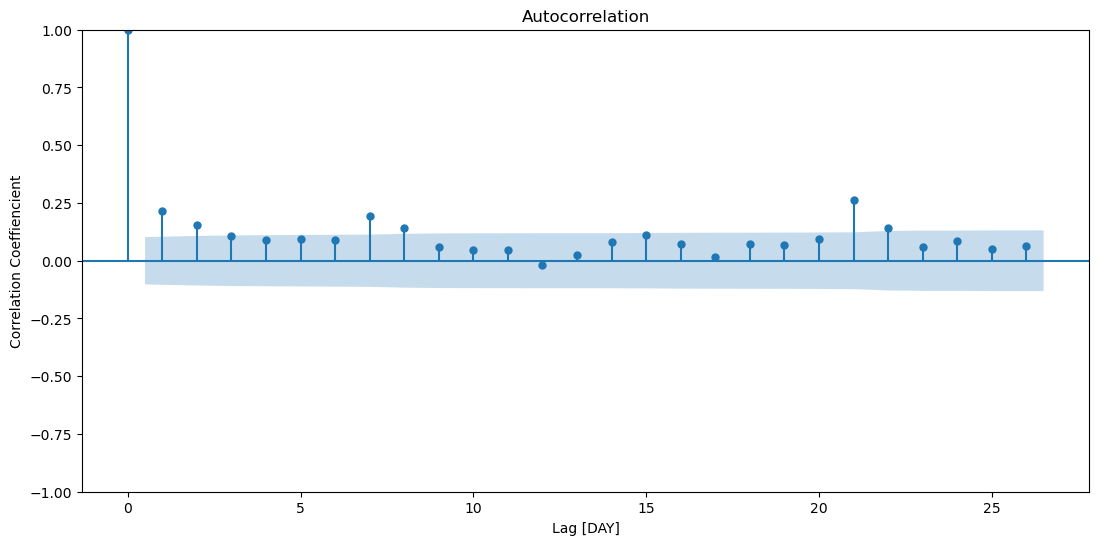

In [65]:
fig,ax = plt.subplots(figsize = (13,6))
plot_acf(df_b,ax=ax)
plt.xlabel('Lag [DAY]')
plt.ylabel('Correlation Coeffiencient');

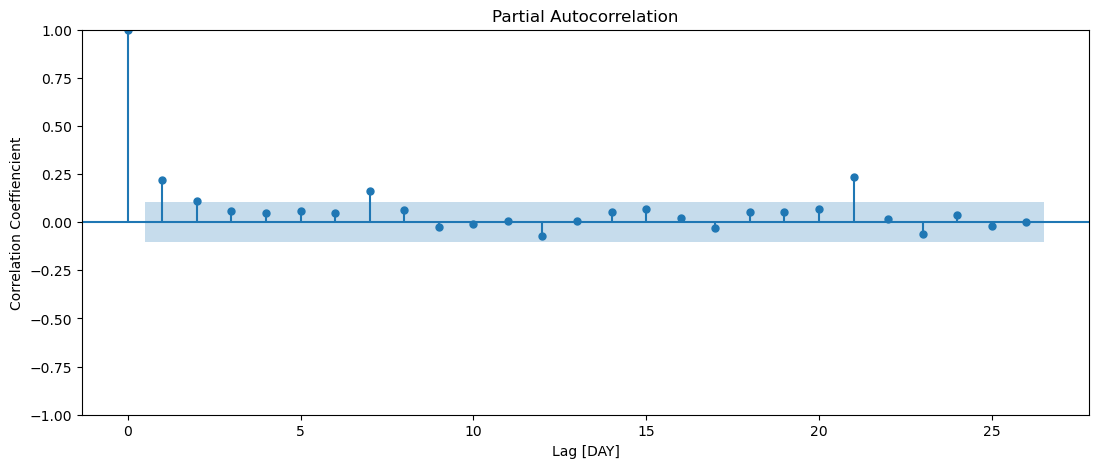

In [66]:
fig , ax = plt.subplots(figsize=(13,5))
plot_pacf(df_b,ax=ax)
plt.xlabel('Lag [DAY]')
plt.ylabel('Correlation Coeffiencient');

In [67]:
cutoff = int(len(df_b)*.85)
y_train = df_b.iloc[:cutoff]
y_test = df_b.iloc[cutoff:]


In [68]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

In [69]:
print(f'the mean absolute error for the training data: {round(mean_absolute_error(y_train,y_pred_baseline),2)}')

the mean absolute error for the training data: 5.81


In [70]:
model = AutoReg(y_train,lags=22).fit()

In [71]:
y_pred = model.predict().dropna()

In [72]:
print(f'The mean absolute error for the Autoreg model: {round(mean_absolute_error(y_train[22:],y_pred),2)}')

The mean absolute error for the Autoreg model: 5.33


In [73]:
y_train_resid = model.resid

In [74]:
y_train_resid.tail()

Date
1959-11-02     7.251528
1959-11-03    -0.442526
1959-11-04     0.320234
1959-11-05    16.538755
1959-11-06    -1.317721
dtype: float64

<AxesSubplot:xlabel='Date'>

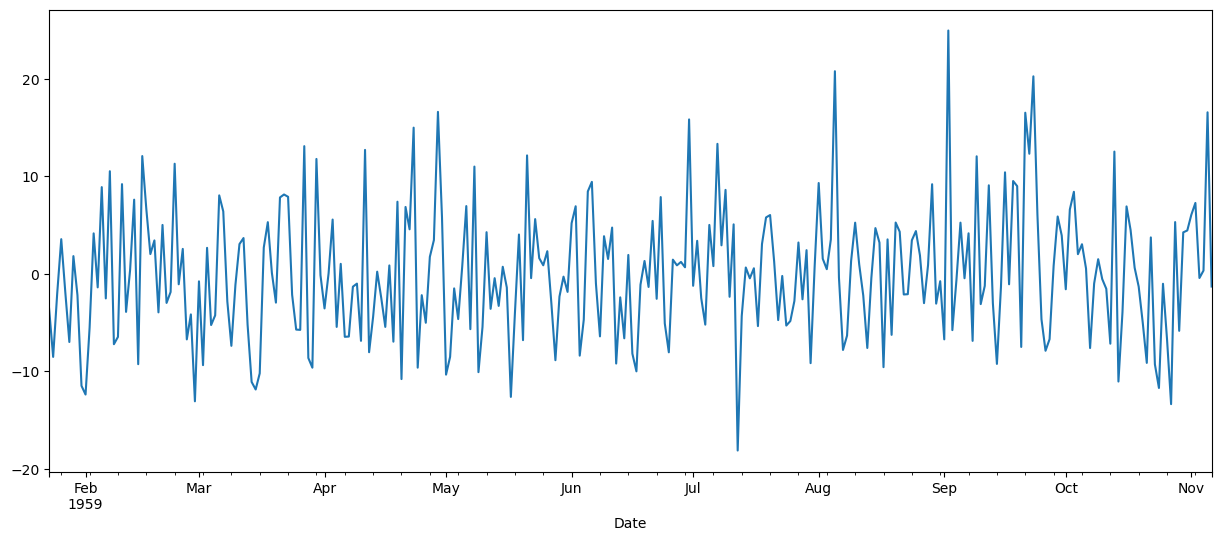

In [75]:
fig ,ax = plt.subplots(figsize=(15,6))
y_train_resid.plot(ax=ax)

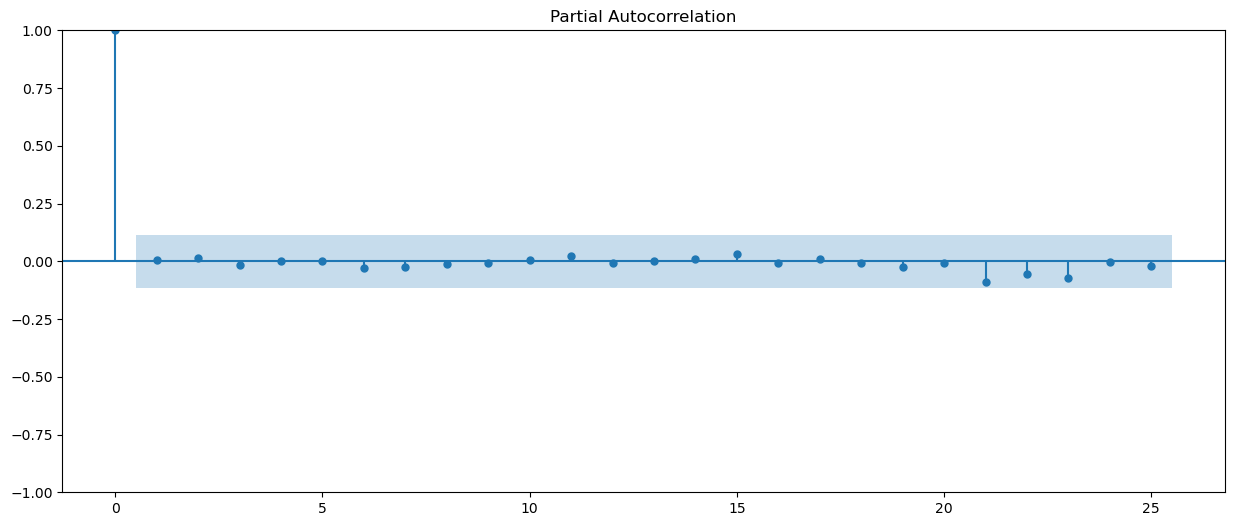

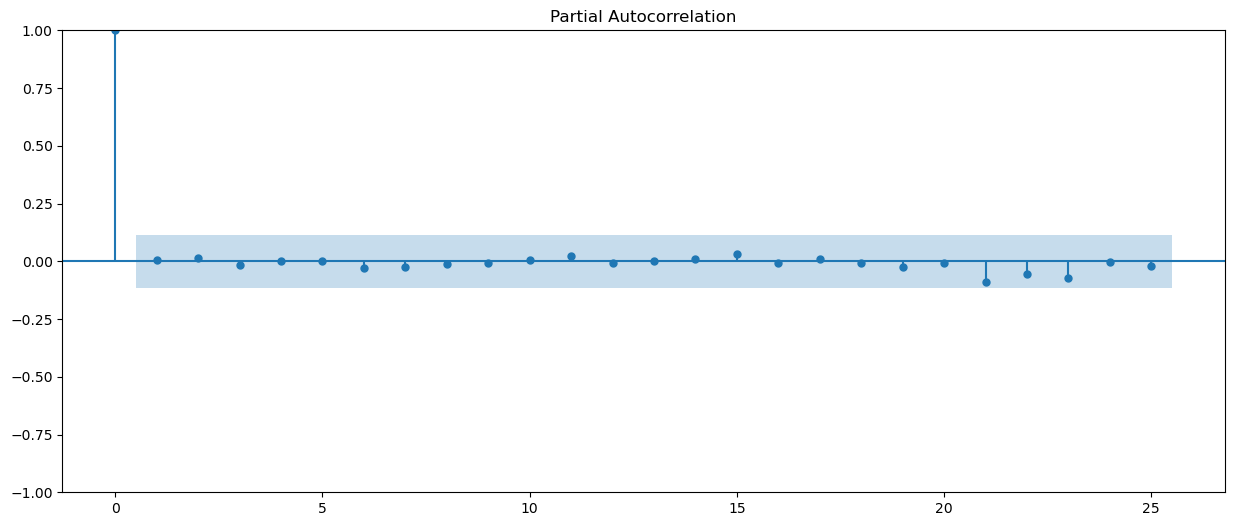

In [76]:
fig,ax = plt.subplots(figsize=(15,6))
plot_pacf(y_train_resid,ax=ax)

In [81]:
y_test_pred = round(model.predict(y_test.index.min(),y_test.index.max()),2)
print(f'Test MAE: {round(mean_absolute_error(y_test,y_test_pred),2)}')

Test MAE: 5.24


In [82]:
type(y_test)

pandas.core.series.Series

In [84]:
df_pred_test =pd.DataFrame(
    {
        'y_test':y_test,
        'y_pred':y_test_pred
    },
    
)

df_pred_test.tail()

,y_test,y_pred
1959-12-27,37,42.92
1959-12-28,52,42.84
1959-12-29,48,42.55
1959-12-30,55,42.50
1959-12-31,50,42.40


In [86]:
fig = px.line(df_pred_test,labels={'value':'Births'})
fig.show()

In [87]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history,lags=22).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [89]:
model.params

const         10.774217
Births.L1      0.146605
Births.L2      0.054973
Births.L3      0.030724
Births.L4      0.028683
Births.L5      0.031801
Births.L6     -0.011328
Births.L7      0.153441
Births.L8      0.068148
Births.L9     -0.018730
Births.L10     0.004221
Births.L11     0.014621
Births.L12    -0.077210
Births.L13    -0.035907
Births.L14     0.010768
Births.L15     0.033195
Births.L16     0.034668
Births.L17    -0.062149
Births.L18     0.029927
Births.L19     0.023959
Births.L20     0.036873
Births.L21     0.234408
Births.L22     0.013546
dtype: float64

In [91]:
df_pred_test = pd.DataFrame({
    'y_test':y_test,
    'y_pred_wfv':y_pred_wfv
})
df_pred_test.tail()

,y_test,y_pred_wfv
1959-12-27,37,37.447449
1959-12-28,52,39.984028
1959-12-29,48,44.638656
1959-12-30,55,43.355532
1959-12-31,50,43.144043


In [93]:
fig = px.line(df_pred_test,labels={'values':'Births'})
fig.show()